In [5]:
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np
from skimage.morphology import disk, skeletonize, remove_small_objects, binary_opening
from skimage.filters.rank import autolevel, median
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv

In [132]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"

# Fetch the image from the URL
response = requests.get(url)
image_data = np.asarray(bytearray(response.content), dtype="uint8")

# Decode the image with OpenCV, using grayscale mode
og_img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
fib_image = og_img[0:3750,:] # Removing data ribbon at bottom
# fib_image = fib_image[0:500,0:500]

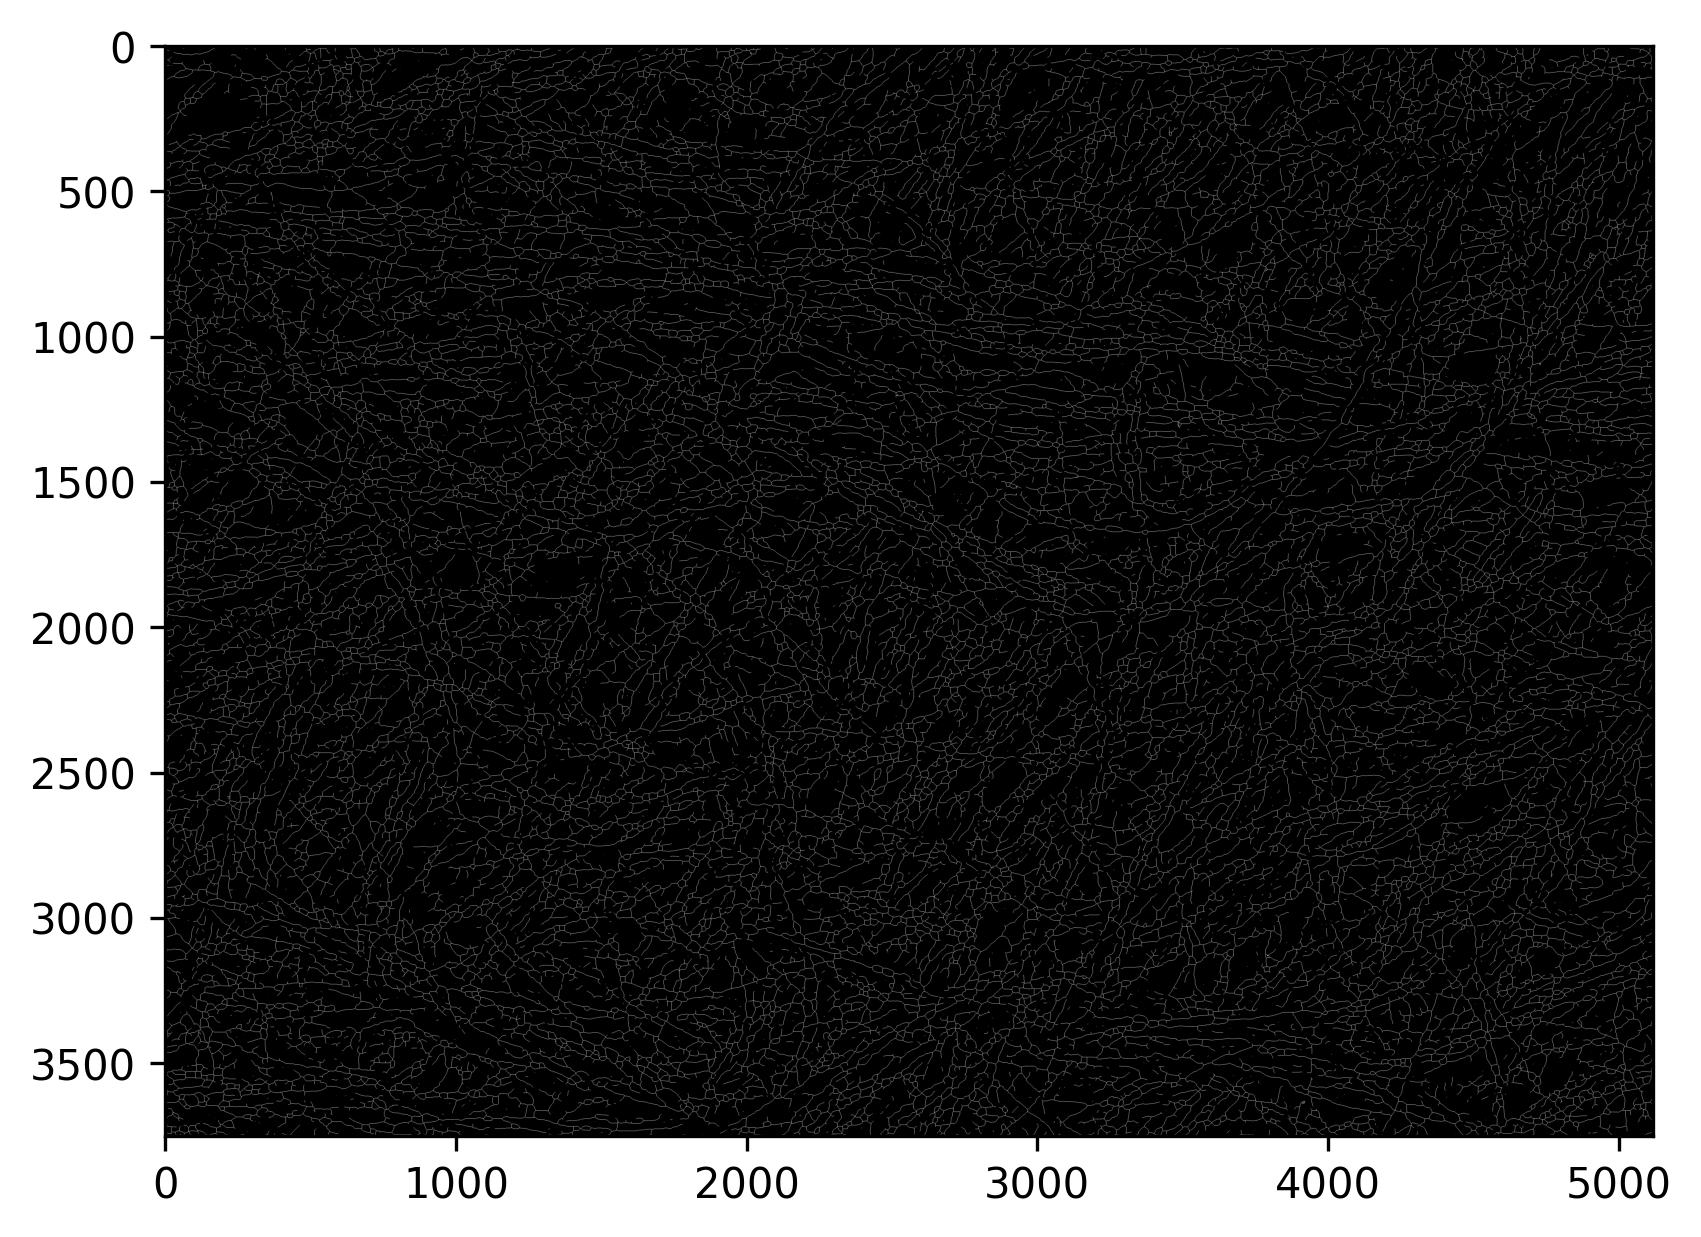

In [133]:
# Threshold the image
ret,img = cv2.threshold(fib_image, 127, 255, 0)

# Step 1: Create an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

# making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
darray = np.zeros((5, 5)) + 1
selem = disk(11)

# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
    #Step 3: Subtract open from the original image
    temp = cv2.subtract(img, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(img, element)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv2.countNonZero(img)==0:
        break

img = cv2.GaussianBlur(skel, (25, 25), 0)
# img = median(img, darray)
# img = autolevel(img, selem)
_, bin_img = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)
# bin_img = cv2.Laplacian(bin_img, cv2.CV_16S, ksize=11)
skel_img = skeletonize(bin_img)
plt.imshow(skel_img, cmap='gray')

In [134]:
def plot_skel(img, dims=None):
    img_og = img
    # Threshold the image
    ret,img = cv2.threshold(img, 127, 255, 0)
    thresh_img = img

    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
    darray = np.zeros((5, 5)) + 1
    selem = disk(11)

    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        #Step 3: Subtract open from the original image
        temp = cv2.subtract(img, open)
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break

    blur_img = cv2.GaussianBlur(skel, (25, 25), 0)
    # img = median(img, darray)
    # img = autolevel(img, selem)
    _, bin_img = cv2.threshold(blur_img, 10, 255, cv2.THRESH_BINARY)
    # bin_img = cv2.Laplacian(bin_img, cv2.CV_16S, ksize=11)
    skel_img = skeletonize(bin_img)

    plt.figure(figsize=(20, 10))  # Create a figure with a custom size

    plt.subplot(2, 3, 1)  # orig image
    plt.imshow(img_og, cmap='gray')
    plt.title('Original Image')
    plt.axis('on')

    plt.subplot(2, 3, 2)  # thresholded image
    plt.imshow(thresh_img, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('on')

    plt.subplot(2, 3, 3)  # thresholded image
    plt.imshow(skel, cmap='gray')
    plt.title('Initial Skeleton Image')
    plt.axis('on')

    plt.subplot(2, 3, 4)  # thresholded image
    plt.imshow(blur_img, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('on')

    # Plot the skeletonized image
    plt.subplot(2, 3, 5)  # This creates a 1x2 grid, second position
    plt.imshow(bin_img, cmap='gray')
    plt.title('Skeletonized Image')
    plt.axis('on')

    plt.subplot(2, 3, 6)  # This creates a 1x2 grid, second position
    plt.imshow(skel_img, cmap='gray')
    plt.title('Skeletonized Image')
    plt.axis('on')

    # Display the plot
    plt.tight_layout()
    plt.show()

    return skel_img

In [135]:
# Set plotting size (default = 100)
pcv.params.dpi = 200

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = .4
pcv.params.text_thickness = 1
pcv.params.line_thickness = 3
pcv.params.color_sequence = "random"

In [136]:
skel_int = skel_img.astype(np.uint8)
skel_int = np.clip(skel_int, 0, 255)
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=skel_int, size=5)
branch_pts = pcv.morphology.find_branch_pts(skel_img=pruned_skel)
tip_pts = pcv.morphology.find_tips(skel_img=pruned_skel)
segments, labels = pcv.morphology.segment_id(skel_img=pruned_skel,
                                             objects=edge_objects)

In [137]:
length_img  = pcv.morphology.segment_path_length(segmented_img=segments, 
                                                  objects=edge_objects, label="default")

In [154]:
labels[0][0][0]

0

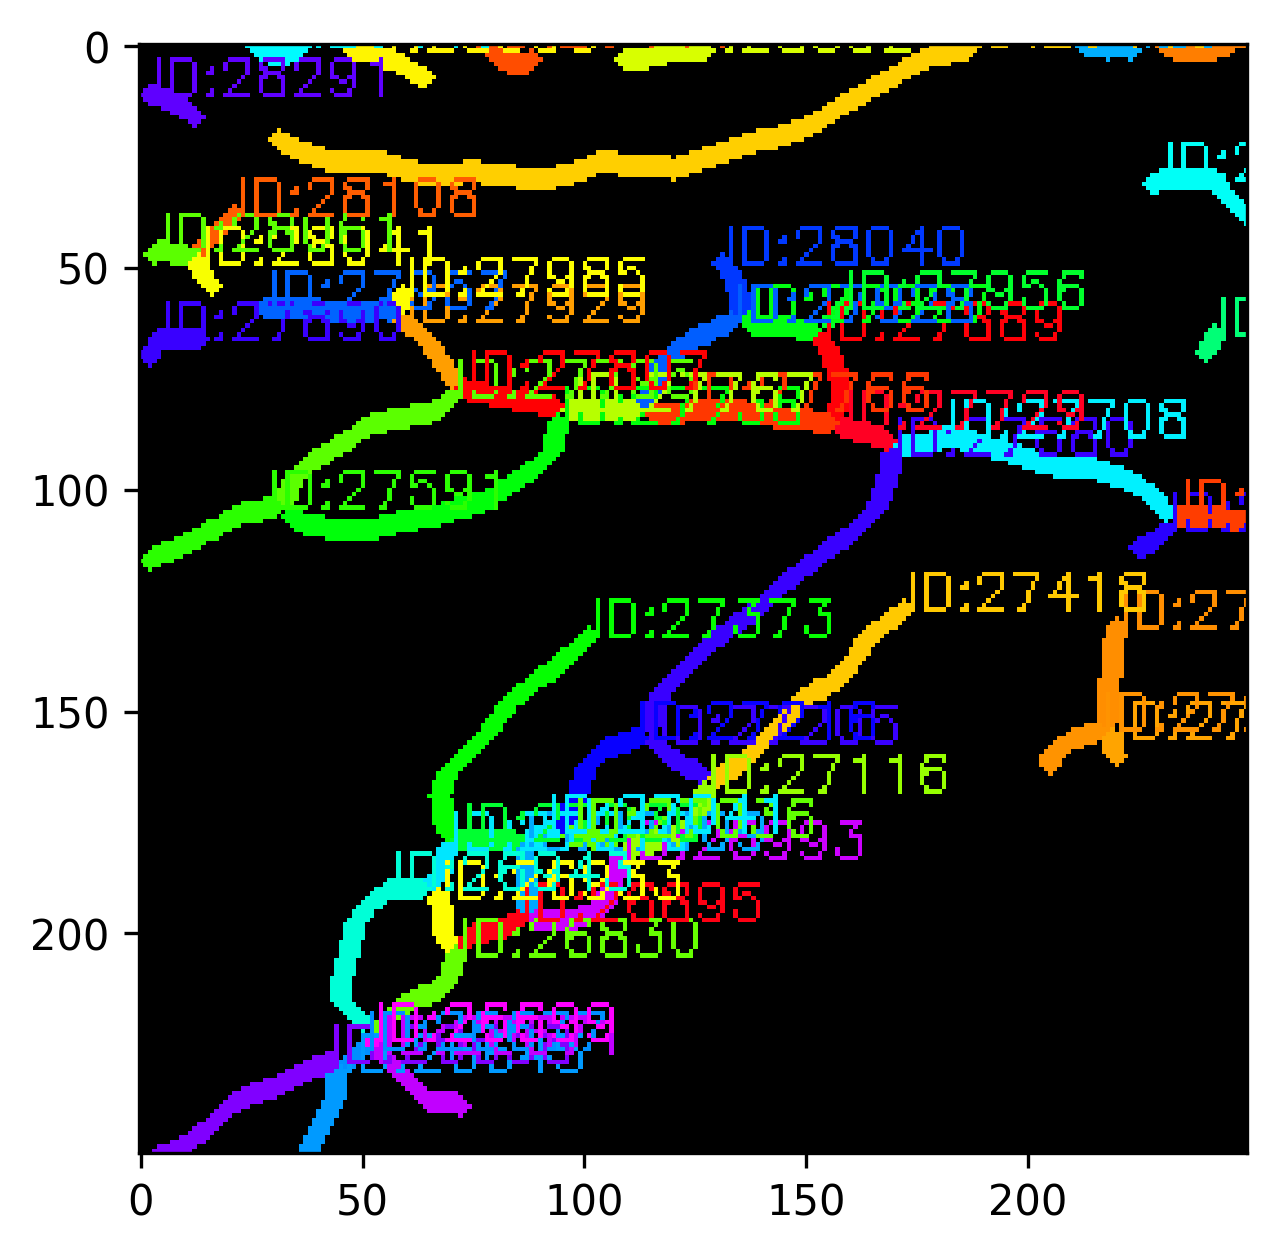

In [151]:
plt.imshow(labels[0:250,0:250])

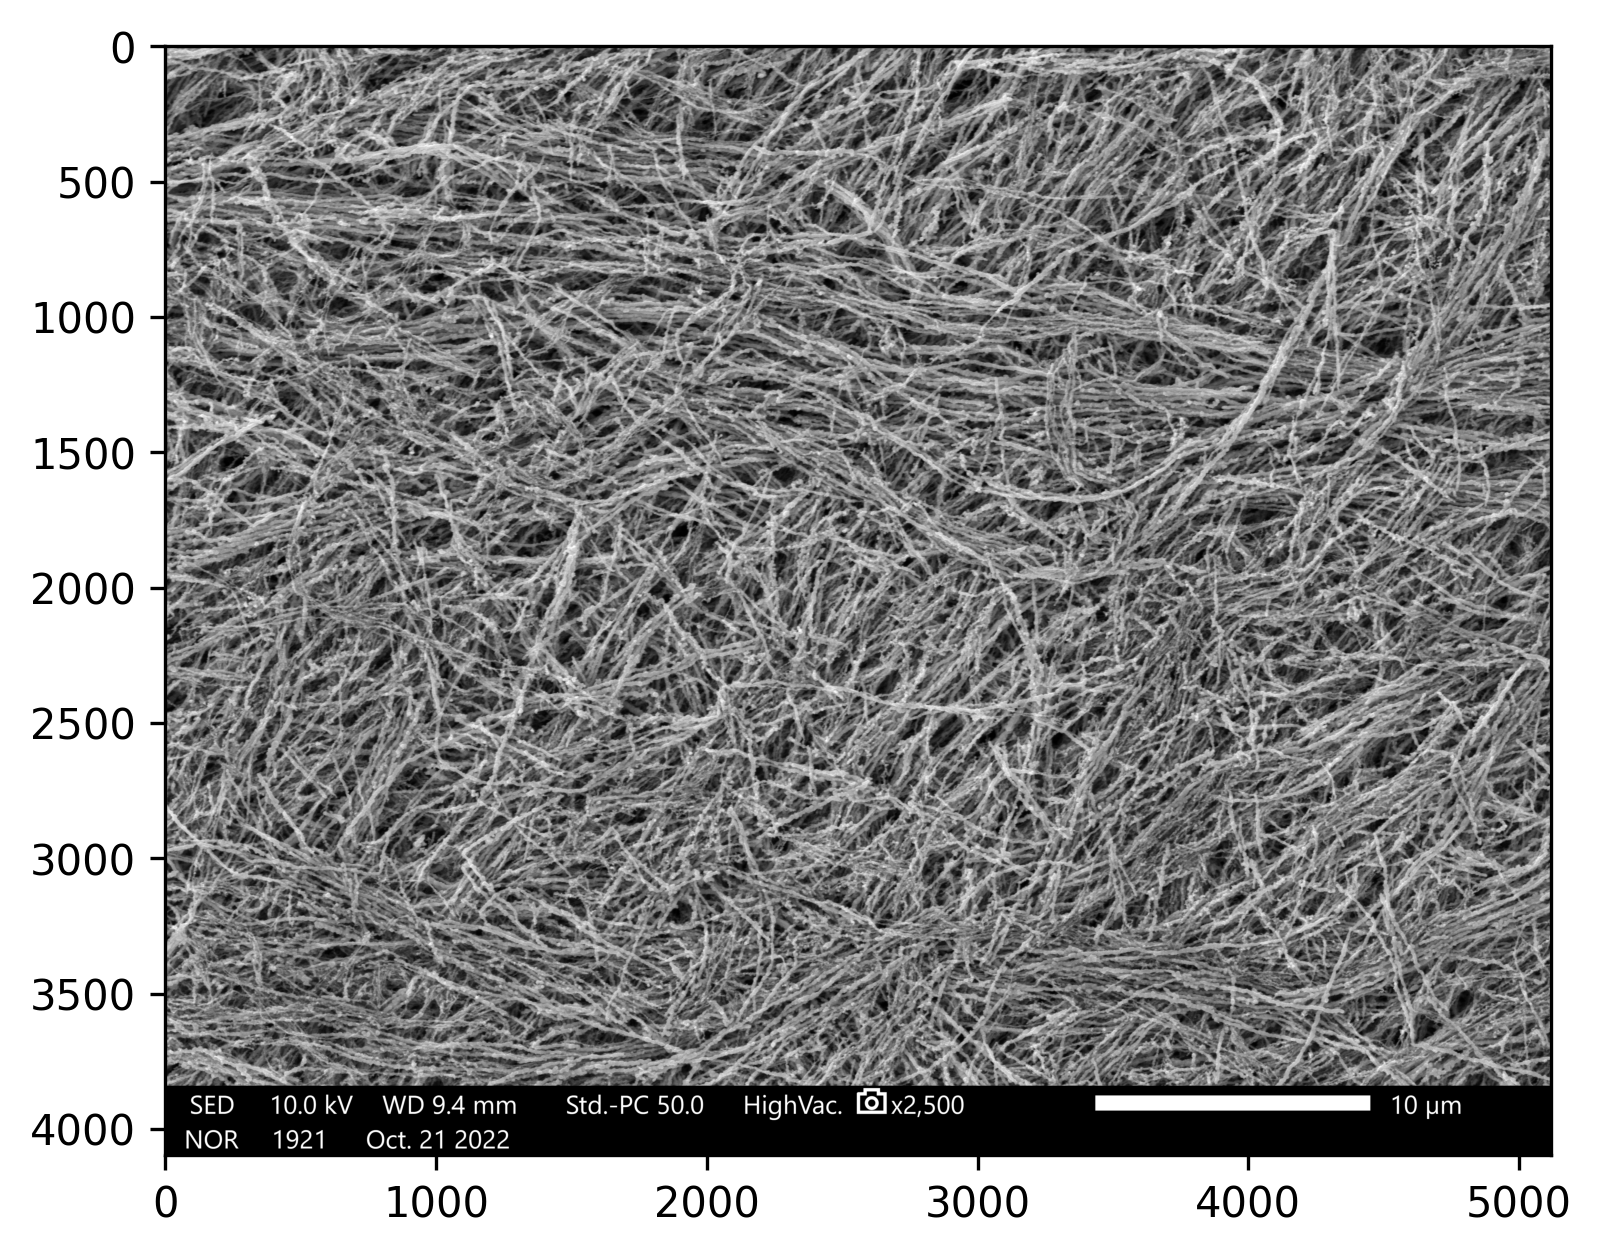

In [143]:
plt.imshow(og_img, cmap='gray')

In [140]:
lengths = pcv.outputs.observations[pcv.params.sample_label]['segment_path_length']['value']
intersections = pcv.outputs.observations[pcv.params.sample_label]['branch_pts']['value']
endpoints = pcv.outputs.observations[pcv.params.sample_label]['tips']['value']

In [156]:
segment_labels = pcv.outputs.observations[pcv.params.sample_label]['segment_id']['value']

KeyError: 'segment_id'

In [142]:
len(lengths), len(intersections), len(endpoints)

(28446, 15971, 9898)

So far what I've done is found a method of skeletonization that works for our specific Cobalt aerogel nanofiber SEM images at 10 micrometer scale. I initially threshold it down to about have the opacity and then begin a unique dilation/erosion while loop which will skeletonize well enough for the image. On the back end of the while loop I implement a Gaussian blur in an attempt to fill broken fibers, threshold again very delicately (~10/255) then do normal skimage's sekeltonization method. This is my overall cleaning process to create my skeletonized image to then move in to the next morphological phase.

Utilizing Plant CV's prune method I deducted any segments smaller than ____ pixels for further noise reduction. In addition to just pruning the skeletonized image for noise it will also fit contours for all the fibers and store them as objects. I then find all endpoints, intersections, id and label each fiber, and find the fiber's arclength.

What I need to still do is modify the segment_sort.py file to instead of differentiating stems and leaves, differentiate between fibers and really implement a merge fiber function based on orientation before and after a branch point (intersection). If I do this then I can find length.